This notebook is adapted from OpenAi's "interacting with CLIP" which can be found <a href="https://github.com/openai/CLIP/blob/main/notebooks/Interacting_with_CLIP.ipynb">here</a>

# Interacting with CLIP

This is a notebook that shows how to install & run CLIP model, calculate the similarity between embedding image and text input

# Preparation for Colab

In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!git clone https://huggingface.co/airesearch/wangchanberta-base-att-spm-uncased
!git clone https://huggingface.co/vikimark/CLIP-MSE-WangchanBerta
!git clone https://github.com/vistec-AI/thai2transformers
!git clone https://github.com/vikimark/Thai-Cross-CLIP

%cd /content/wangchanberta-base-att-spm-uncased/
!git lfs pull
%cd /content/CLIP-MSE-WangchanBerta/
!git lfs pull
%cd /content
!cp /content/thai2transformers/thai2transformers/preprocess.py /content

!pip install timm
!pip install transformers
!pip install sentencepiece
!pip install pythainlp
!pip install pythainlp[translate]
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-6z9dlzc4
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-6z9dlzc4
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369387 sha256=2baf492e677810823a13f43a525938d7e5e1261952ddc78c78266331949cbcbb
  Stored in directory: /tmp/pip-ephem-wheel-cache-z4gzi4ue/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip
Cloning into 'wangchanberta-base-att-spm-uncased'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (251/251), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 251 (delta 156), reused 251 (delta 156), pack-reused 0
Receiving objects: 10

In [2]:
import numpy as np
import torch
import sys
sys.path.append("./Thai-Cross-CLIP")
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 1.12.0+cu113


# Loading the model

In [16]:
from source.model import *
from source.config import *
from preprocess import process_transformers
import clip
from PIL import Image

text_model = TextModel().to(CFG.device)
text_model.load_state_dict(torch.load("/content/CLIP-MSE-WangchanBerta/text_MSE_2m.pt", map_location=CFG.device))
text_model.eval().requires_grad_(False)

clip_model, compose = clip.load('ViT-B/32')
clip_model.to(CFG.device).eval()
input_resolution = clip_model.visual.input_resolution

print("Text encoder parameters:", f"{np.sum([int(np.prod(p.shape)) for p in text_model.parameters()]):,}")
print("Input image resolution:", input_resolution)

Some weights of the model checkpoint at wangchanberta-base-att-spm-uncased were not used when initializing CamembertModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Text encoder parameters: 105,901,824
Input image resolution: 224


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

In [17]:
compose

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fe7fb41b710>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Setting up input images and texts

We are going to feed 1 image and 3 textual descriptions to the model, and compare the similarity between the corresponding features. (you could try changing image url and labels to play around!)

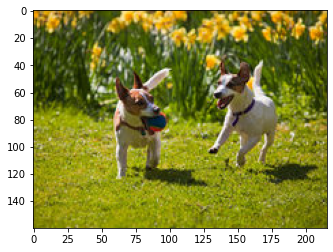

แมวสองตัวกำลังปีนต้นไม้
หมาสองตัวกำลังวิ่งเล่นในทุ่ง
สุนัขสองตัวกำลังกินอาหารอย่างมุมมาม


In [29]:
from urllib.request import urlopen
import matplotlib.pyplot as plt

img = Image.open(urlopen('https://thumbs.dreamstime.com/t/jack-fetch-%D0%B8%D0%B3%D1%80%D0%B0%D1%8F-terriers-russell-20071227.jpg'))
plt.imshow(img)
im = img.convert('RGB').resize((224, 224))
im = torch.tensor(np.array(im)).permute(2, 0, 1)/255
im = im.unsqueeze(0).to(CFG.device)

labels = ['แมวสองตัวกำลังปีนต้นไม้', 'หมาสองตัวกำลังวิ่งเล่นในทุ่ง', 'สุนัขสองตัวกำลังกินอาหารอย่างมุมมาม']
plt.show()
print(*labels, sep='\n')

# Building features

We normalize the image, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [30]:
with torch.no_grad():
    image_feature = clip_model.encode_image(im).float()
    text_features = []
    for label in labels:
      text_feature = text_model.encode_text([process_transformers(label)]).to(CFG.device).float()
      text_features.append(text_feature)

print("image feature shape :", image_feature.shape)
print("text  feature shape (shape of each):", text_features[0].shape)

image feature shape : torch.Size([1, 512])
text  feature shape (shape of each): torch.Size([1, 512])


# Calculating cosine similarity

We normalize the features and calculate the cosine similarity of each pair

แมวสองตัวกำลังปีนต้นไม้: tensor(0.7963)
หมาสองตัวกำลังวิ่งเล่นในทุ่ง: tensor(0.6822)
สุนัขสองตัวกำลังกินอาหารอย่างมุมมาม: tensor(0.7335)
Prediction: หมาสองตัวกำลังวิ่งเล่นในทุ่ง


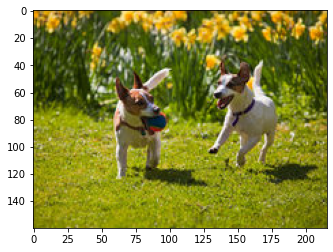

In [42]:
image_feature /= image_feature.norm(dim=-1, keepdim=True).float()

similarity = torch.nn.CosineSimilarity()
losses = []

for i, text_f in enumerate(text_features):
    text_f /= text_f.norm(dim=-1, keepdim=True).float()
    loss = 1 - similarity(image_feature, text_f)
    losses.append(loss[0])
    print(labels[i] + ":", loss[0])

plt.imshow(img)
plt.plot()
print("Prediction:", labels[np.argmin(losses)])